## Setup

In [1]:
%pylab inline
from helper_functions import *
from doublet_detector import *
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

## Load data

In [3]:

sample_name = ['P9A', 'P11A', 'P11B', 'P12A']

min_tot = [1000 for s in sample_name] # initial guess for total transcript counts threshold
nSamp = len(sample_name)
input_path = 'raw_counts/'



In [4]:
# D stores all the data; one entry per library
D = {}

for j,s in enumerate(sample_name):
    D[s] = {}
    D[s]['meta'] = {'min_tot': min_tot[j]}
    

In [5]:
# load counts matrices -- try to load from npz file (fast), 
# otherwise load from text file (slow) and build npz file for next time

for s in sample_name:
    print '_________________', s

    if os.path.isfile(input_path + s + '.raw_counts.unfiltered.npz'):
        print 'Loading from npz file'
        D[s]['E'] = scipy.sparse.load_npz(input_path + s + '.raw_counts.unfiltered.npz')
    else:
        print 'Loading from text file'
        D[s]['E'] = text_to_sparse(input_path + s + '.counts.tsv.gz', 
                                   delim = '\t', start_row = 1, start_column = 1, 
                                   get_gene_names = False, get_barcodes = False)
        scipy.sparse.save_npz(input_path + s + '.raw_counts.unfiltered.npz', D[s]['E'], compressed = True)
    print D[s]['E'].shape
    



_________________ P9A
Loading from npz file
(1817, 28205)
_________________ P11A
Loading from npz file
(1832, 28205)
_________________ P11B
Loading from npz file
(1891, 28205)
_________________ P12A
Loading from npz file
(1393, 28205)


In [6]:
gene_list = np.array(load_genes(input_path + 'genes.txt'))

## Filter cells by total counts

P9A 1446 / 1817 2409.0 2555.26279391
P11A 1426 / 1832 1764.5 1885.15217391
P11B 1096 / 1891 1767.5 1902.42518248
P12A 1081 / 1393 1939.0 2291.71785384


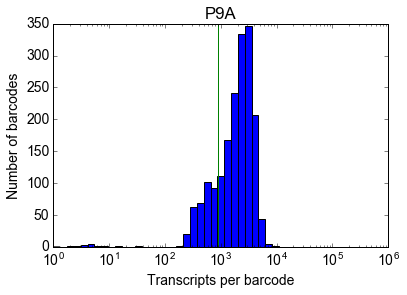

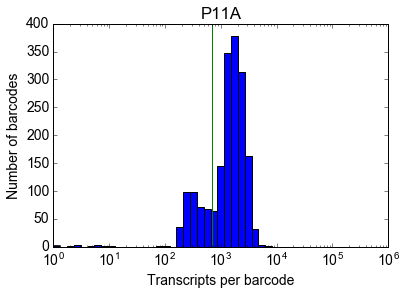

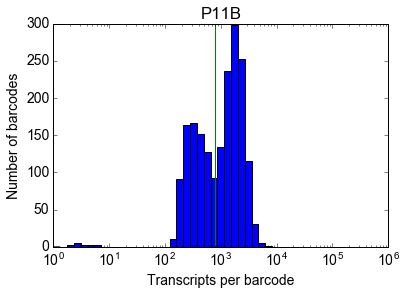

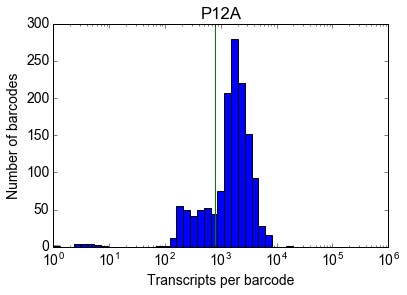

In [7]:
# plot total counts histograms - don't actually filter out any barcodes yet


# adjust total counts thresholds
D['P9A']['meta']['min_tot'] = 900
D['P11A']['meta']['min_tot'] = 700
D['P11B']['meta']['min_tot'] = 800
D['P12A']['meta']['min_tot'] = 800

for s in sample_name:
    D[s]['total_counts'] = np.sum(D[s]['E'], axis=1).A[:,0]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(D[s]['total_counts'], bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    
    ax.plot([D[s]['meta']['min_tot'],D[s]['meta']['min_tot']],ax.get_ylim());
    title(s)


    ix = D[s]['total_counts'] >= D[s]['meta']['min_tot']
    print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])


In [8]:
# Actually filter out low-count barcodes

for s in sample_name:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    D[s]['cell_index'] = np.arange(D[s]['E'].shape[0])
    tmpfilt = np.nonzero(D[s]['total_counts'] >= D[s]['meta']['min_tot'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
del tmpfilt

---  P9A ---
Pre-filter: 1817 barcodes
Post-filter: 1446 barcodes
---  P11A ---
Pre-filter: 1832 barcodes
Post-filter: 1426 barcodes
---  P11B ---
Pre-filter: 1891 barcodes
Post-filter: 1096 barcodes
---  P12A ---
Pre-filter: 1393 barcodes
Post-filter: 1081 barcodes


## Filter cells by mito fraction

In [9]:
# get mitochondrial genes

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('mt-')]
print [gene_list[i] for i in mt_ix]

['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']


1446 1303
1426 1384
1096 1056
1081 1047


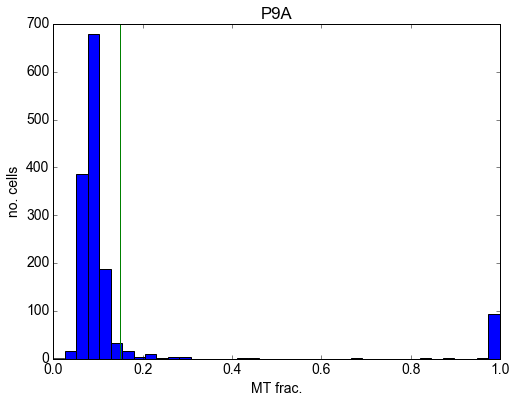

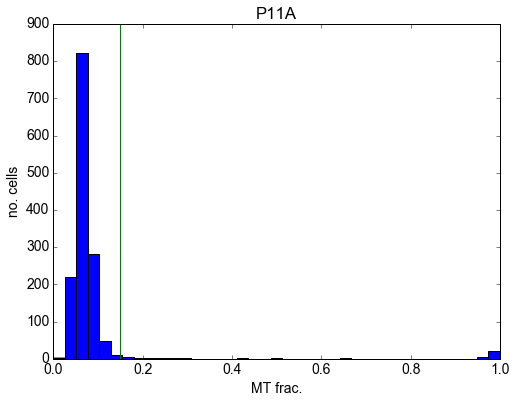

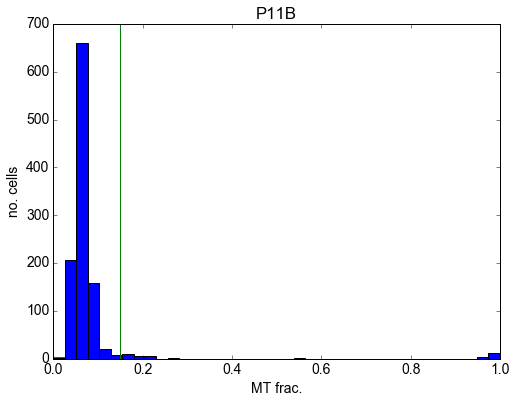

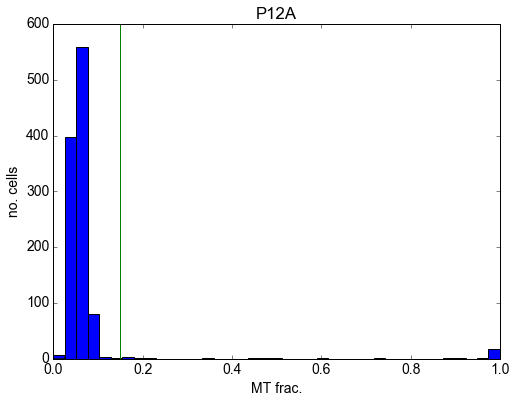

In [10]:
# plot mito-gene frac histograms - don't actually filter out any cells yet

# set mito-gene frac threshold
for s in sample_name:
    D[s]['meta']['max_mt'] = 0.15

for s in sample_name:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')

    D[s]['mito_frac'] = np.sum(D[s]['E'][:,mt_ix], axis=1).A[:,0] / np.sum(D[s]['E'], axis=1,dtype=float).A[:,0]

    ax.hist(D[s]['mito_frac'], cumulative=False, 
            bins=np.linspace(0, 1, 40))

    ax.plot([D[s]['meta']['max_mt'],D[s]['meta']['max_mt']],ax.get_ylim());
    title(s)

    print D[s]['E'].shape[0], np.sum(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])


In [11]:
# Actually filter out mito-high cells

for s in sample_name:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
del tmpfilt

---  P9A ---
Pre-filter: 1446 barcodes
Post-filter: 1303 barcodes
---  P11A ---
Pre-filter: 1426 barcodes
Post-filter: 1384 barcodes
---  P11B ---
Pre-filter: 1096 barcodes
Post-filter: 1056 barcodes
---  P12A ---
Pre-filter: 1081 barcodes
Post-filter: 1047 barcodes


## Merge data, normalize

In [12]:
# create master dataset (all SPRING subsets will refer back to this)

samp_lookup = {}
samp_id_flat = np.array([],dtype=str)
for s in D.keys():
    samp_id_flat = np.append(samp_id_flat, [s] * D[s]['E'].shape[0])
    
E = scipy.sparse.lil_matrix((len(samp_id_flat), len(gene_list)), dtype=int)
total_counts = np.zeros(len(samp_id_flat), dtype=int)
mito_frac = np.zeros(len(samp_id_flat), dtype=float)

for s in D.keys():
    print s
    E[samp_id_flat == s, :] = D[s]['E']
    total_counts[samp_id_flat == s] = D[s]['total_counts']
    mito_frac[samp_id_flat == s] = D[s]['mito_frac']

E = E.tocsc()

P11B
P9A
P11A
P12A


In [13]:
# remove genes that are not expressed by any cells

keep_genes = (E.sum(0) > 0).A.squeeze()
print sum(keep_genes), '/', len(keep_genes)

E = E[:,keep_genes]
gene_list = gene_list[keep_genes]

21619 / 28205


In [14]:
# normalize by total counts

E = tot_counts_norm_sparse(E)[0]

## Save base directory files

In [15]:
# Set path for saving data -- you'll have to change this for your own setup.
# This path should be a subdirectory of your local copy of SPRING,
# specifically, {path_to_SPRING}/data/client_datasets/{main_dataset_name}. 
# See example below, where springViewer_1_6_dev.html is located in ../

main_spring_dir = '../data/client_datasets/example/'

if not os.path.exists(main_spring_dir):
    os.makedirs(main_spring_dir)
    


In [24]:
np.savetxt(main_spring_dir + 'genes.txt', gene_list, fmt='%s')

In [26]:
# save master expression matrix in hdf5 format

import h5py

print 'Saving hdf5 file for fast gene loading...'
E = E.tocsc()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_genes.hdf5', 'w')
counts_group = hf.create_group('counts')
cix_group = hf.create_group('cell_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iG, g in enumerate(gene_list):
    if iG % 3000 == 0:
        print iG, '/', len(gene_list)
    counts = E[:,iG].A.squeeze()
    cell_ix = np.nonzero(counts)[0]
    counts = counts[cell_ix]
    
    counts_group.create_dataset(g, data = counts)
    cix_group.create_dataset(g, data = cell_ix)

hf.close()

##############

print 'Saving hdf5 file for fast cell loading...'
E = E.tocsr()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_cells.hdf5', 'w')
counts_group = hf.create_group('counts')
gix_group = hf.create_group('gene_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iC in range(E.shape[0]):
    if iC % 3000 == 0:
        print iC, '/', E.shape[0]
    counts = E[iC,:].A.squeeze()
    gene_ix = np.nonzero(counts)[0]
    counts = counts[gene_ix]
    
    counts_group.create_dataset(str(iC), data = counts)
    gix_group.create_dataset(str(iC), data = gene_ix)

hf.close()


    

Saving hdf5 file for fast gene loading...
0 / 21619
3000 / 21619
6000 / 21619
9000 / 21619
12000 / 21619
15000 / 21619
18000 / 21619
21000 / 21619
Saving hdf5 file for fast cell loading...
0 / 4790
3000 / 4790


In [27]:
# It turns out scipy sparse npz format is faster in some cases. Save this too.

E = E.tocsc()
scipy.sparse.save_npz(main_spring_dir + '/counts_norm.npz', E, compressed = False)

## Save SPRING files

#### Save individual samples

In [16]:
g2m_genes = ['Ube2c','Hmgb2','Hmgn2','Tuba1b','Mki67','Ccnb1','Tubb','Top2a','Tubb4b']

________________ P11A
Filtering genes
Using 876 genes
Running PCA
Building kNN graph
kNN built in 0.12518 sec
Entire graph function: 0.14698 sec
Saving SPRING files to ../data/client_datasets/example/P11A
Running ForceAtlas2
18.3326117992
________________ P11B
Filtering genes
Using 841 genes
Running PCA
Building kNN graph
kNN built in 0.08142 sec
Entire graph function: 0.09884 sec
Saving SPRING files to ../data/client_datasets/example/P11B
Running ForceAtlas2
17.7587499619
________________ P12A
Filtering genes
Using 1089 genes
Running PCA
Building kNN graph
kNN built in 0.09454 sec
Entire graph function: 0.11190 sec
Saving SPRING files to ../data/client_datasets/example/P12A
Running ForceAtlas2
17.6634480953


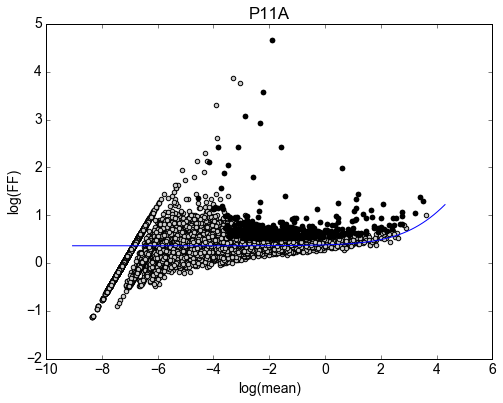

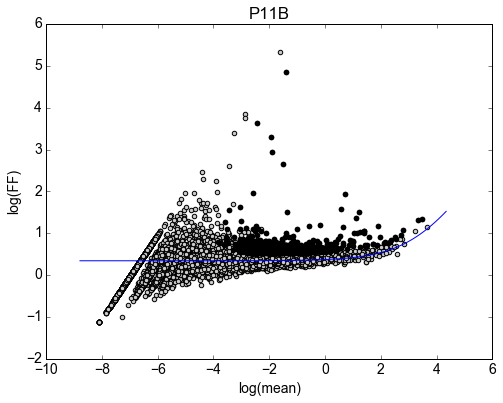

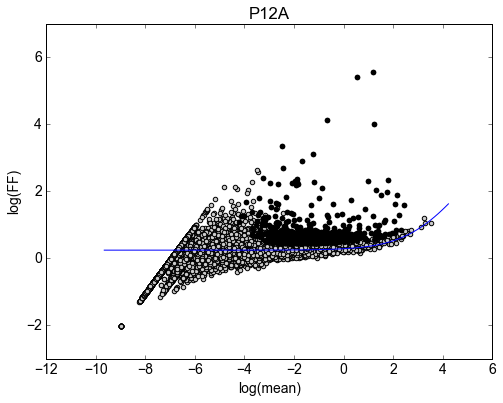

In [17]:
# For faster knn graph building, install a library called annoy: "pip install annoy"
# This is especially noticeable if running the doublet detector (i.e. when run_woublet=True)

E = E.tocsc()

for s in sample_name:
    t0 = time.time()
    print '________________', s
    
    cell_ix = samp_id_flat == s
    
    out = run_all_spring_1_6(E[cell_ix,:],
                     list(gene_list), s, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 85, 
                     show_vscore_plot = True, num_pc = 25, pca_method = '', k_neigh=4, use_approxnn = False,
                     output_spring = True, num_force_iter = 200, 
                     #exclude_corr_genes_list=[g2m_genes], exclude_corr_genes_minCorr=0.2
                     )
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0


#### Save merged samples

In [19]:
# set up various merged samples

merge_setup = {'allMerged': sample_name,
               'P11Merged': ['P11A', 'P11B']
               }

________________ P11Merged
Filtering genes
Using 1095 genes
Running PCA
Building kNN graph
kNN built in 0.54892 sec
Entire graph function: 0.64936 sec
Saving SPRING files to ../data/client_datasets/example/P11Merged
Running ForceAtlas2
20.2960441113
________________ allMerged
Filtering genes
Using 1298 genes
Running PCA
Building kNN graph
kNN built in 1.22907 sec
Entire graph function: 1.27559 sec
Saving SPRING files to ../data/client_datasets/example/allMerged
Running ForceAtlas2
29.7396640778


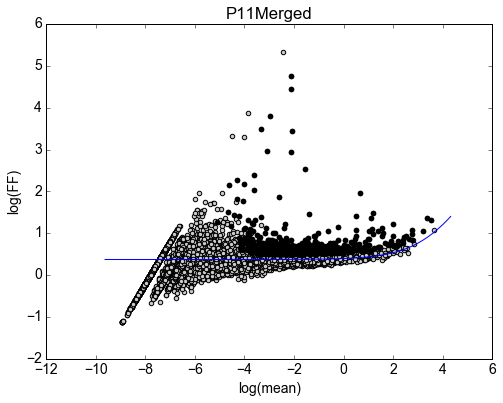

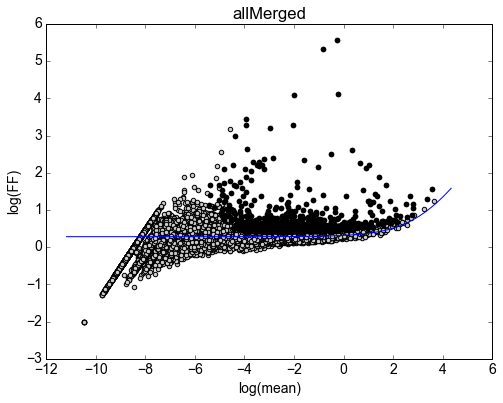

In [20]:
# save data including cell cycle-correlated genes

for s, smerge in merge_setup.items():
    t0 = time.time()
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(gene_list), s, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 85, 
                     show_vscore_plot = True, num_pc = 25, pca_method = '', k_neigh=4, use_approxnn = False,
                     #exclude_corr_genes_list=[g2m_genes], exclude_corr_genes_minCorr=0.2,
                     output_spring = True, num_force_iter = 200,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0


________________ P11Merged
Filtering genes
Using 1095 genes
32
['2810417H13Rik' 'Arl6ip1' 'Aspm' 'Birc5' 'Ccnb2' 'Cdc25b' 'Cdca8' 'Cdk1'
 'Cenpa' 'Ckap2l' 'Cks2' 'H2afv' 'H2afz' 'Hist1h2ap' 'Hmgb2' 'Kpna2'
 'Mad2l1' 'Mki67' 'Nucks1' 'Ppia' 'Pttg1' 'Rad21' 'Rangap1' 'Stmn1' 'Tk1'
 'Top2a' 'Tpx2' 'Tuba1b' 'Tuba1c' 'Tubb4b' 'Tubb5' 'Ube2c']
Now using 1063 genes
Running PCA
Building kNN graph
kNN built in 0.42675 sec
Entire graph function: 0.46967 sec
Saving SPRING files to ../data/client_datasets/example/P11Merged_noCC
Running ForceAtlas2
22.0320341587
________________ allMerged
Filtering genes
Using 1298 genes
27
['2810417H13Rik' 'Arl6ip1' 'Birc5' 'Ccnb2' 'Cdc25b' 'Cdk1' 'Cenpa' 'H2afv'
 'H2afz' 'Hist1h2ap' 'Hmgb2' 'Kpna2' 'Mad2l1' 'Mki67' 'Plk1' 'Ppia' 'Pttg1'
 'Rangap1' 'Stmn1' 'Tk1' 'Top2a' 'Tpx2' 'Tuba1b' 'Tuba1c' 'Tubb4b' 'Tubb5'
 'Ube2c']
Now using 1271 genes
Running PCA
Building kNN graph
kNN built in 1.43398 sec
Entire graph function: 1.48460 sec
Saving SPRING files to ../data/cl

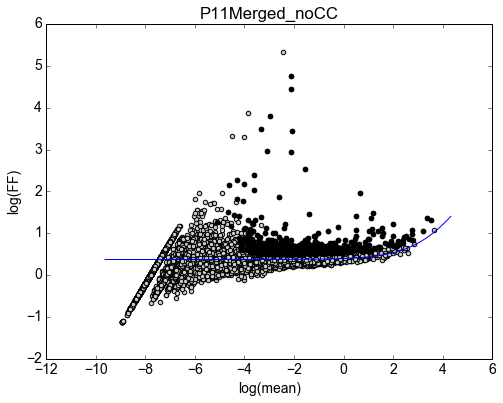

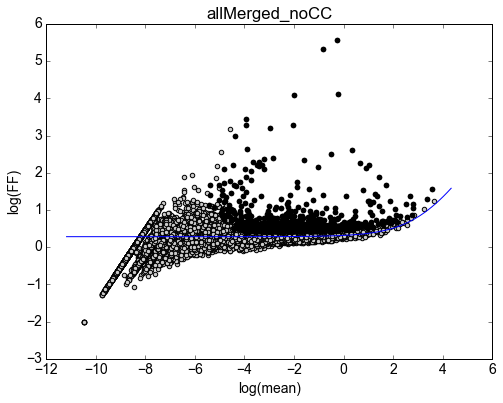

In [21]:
# save data excluding cell cycle-correlated genes

for s, smerge in merge_setup.items():
    t0 = time.time()
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    subset_name = s + '_noCC'
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(gene_list), subset_name, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 85, 
                     show_vscore_plot = True, num_pc = 25, pca_method = '', k_neigh=4, use_approxnn = False,
                     exclude_corr_genes_list=[g2m_genes], exclude_corr_genes_minCorr=0.2,
                     output_spring = True, num_force_iter = 200,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    np.save(main_spring_dir + subset_name + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + subset_name + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0
